# Basic example with Argo data

In [26]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import intake
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

Here is a quick example of what you can do and how to use :class:`pyxpcm.pcm`.

First, let's import the PCM model constructor

In [27]:
from pyxpcm.pcmodel import pcm

A Profile Classification Model (PCM) can be created independently of any dataset using the :class:`pyxpcm.pcm` class constructor:

In [28]:
import pyxpcm
from pyxpcm import datasets as pcmdata
from pyxpcm import plot as pcmplot

In [29]:
# Hidden cell
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib as mpl

## Load data

In [3]:
ds = pcmdata.load_argo()
print('This dataset holds: %.1f MB' % (ds.nbytes / 1e6))
print(ds)

This dataset holds: 34.3 MB
<xarray.Dataset>
Dimensions:    (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
Attributes:
    Prepared by:  G. Maze
    Institution:  Ifremer/LOPS
    Data DOI:

## Define/fit/predict a standard pyXpcm

In [4]:
# Define vertical axis and features to use:
z = ds['DEPTH'].values[0:280]
z = np.arange(0.5,-1000,-10.)
features_pcm = {'temperature': z}
features_in_ds = {'temperature': 'TEMP'}

# features_pcm = {'temperature': z, 'salinity': z}
# features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

# Note that here we use the dataset vertical axis for performance reasons (no need for interpolation)
# We could use anything, eg: z = np.arange(-1000,0,10)

In [5]:
# Instantiate a new pyXpcm:
m = pcm(K=8, features=features_pcm)

# Fit:
ds.pyxpcm.fit(m, features=features_in_ds)
print(m,"\n")

# Hard/Fuzzy classify data:
ds = ds.pyxpcm.predict(m, features=features_in_ds, inplace=True)
ds = ds.pyxpcm.predict_proba(m, features=features_in_ds, inplace=True)

# Compute robustness of the classification:
ds = ds.pyxpcm.robustness(inplace=True)
ds = ds.pyxpcm.robustness_digit(inplace=True)

# Compute quantiles:
ds = ds.compute() # This is necessary if data are in dask arrays
for vname in ['TEMP', 'PSAL']:
    ds = ds.pyxpcm.quantile([0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)

print(ds)

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.pcmodel.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: -0.204010 

<xarray.Dataset>
Dimensions:             (DEPTH: 282, N_PROF: 7560, pcm_class: 8, quantile: 3)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5 6 7
  * DEPTH               (DEPTH) float32 0.0 -5.0 -10.0 ... -1400.0 -1405.0
  * quantile            (quantile) float64 0.05 0.5 0.95
  * N_PROF              (N_PROF) int64 0 1 2 3 4 5 ... 7555 7556 7557 7558 7559
Data variables:
    PSAL_Q              (pcm_class, quantile, DEPTH) float64 34.94 ... 34.94
    TEMP_Q              (pcm_class, quantile, DEPTH) float64 6.44 .

In [6]:
# pyXpcm variables added to the dataset can be removed with:
# print('Before:', ds.data_vars)
# ds = ds.pyxpcm.clean()
# print('After cleaning:', ds.data_vars)

## Figure of results

### Maps

#### Labels

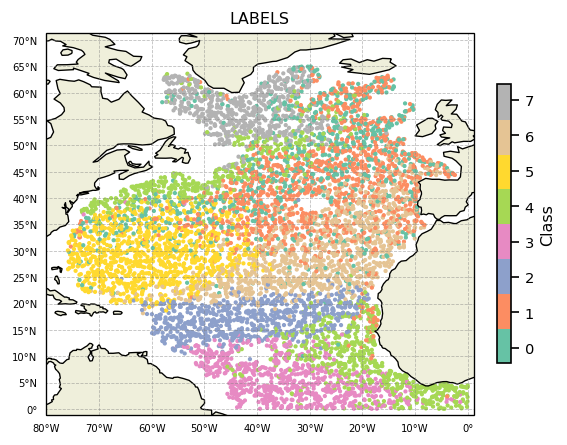

In [7]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = m.plot.cmap()
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3, c=ds['PCM_LABELS'], cmap=cmap, transform=proj, vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

gl = pcmplot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS')
plt.show()

#### Robustness

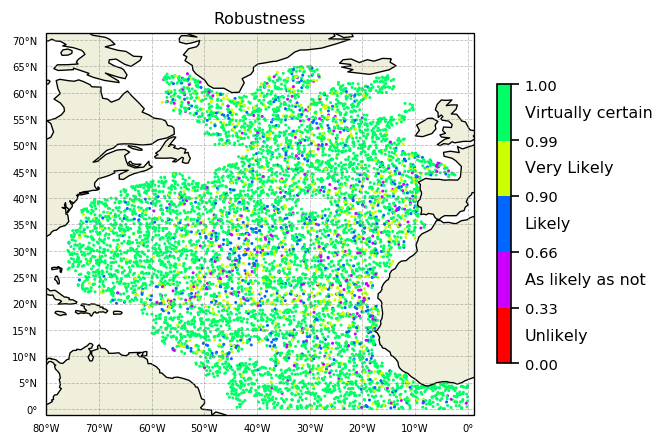

In [8]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = pcmplot.cmap_robustess()
boundaries = ds['PCM_ROBUSTNESS_CAT'].attrs['bins']
rowl0 = ds['PCM_ROBUSTNESS_CAT'].attrs['legend']
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=1, c=ds['PCM_ROBUSTNESS'], cmap=cmap, norm=norm, transform=proj)
cl = plt.colorbar(sc,ax=ax, fraction=0.03)
for (i,j) in zip(np.arange(0.1,1,1/5), rowl0):
    cl.ax.text(2, i, j, ha='left', va='center')

gl = pcmplot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Robustness')
plt.show()

### Vertical profiles

#### Quantiles

Used to plot the typical class profiles

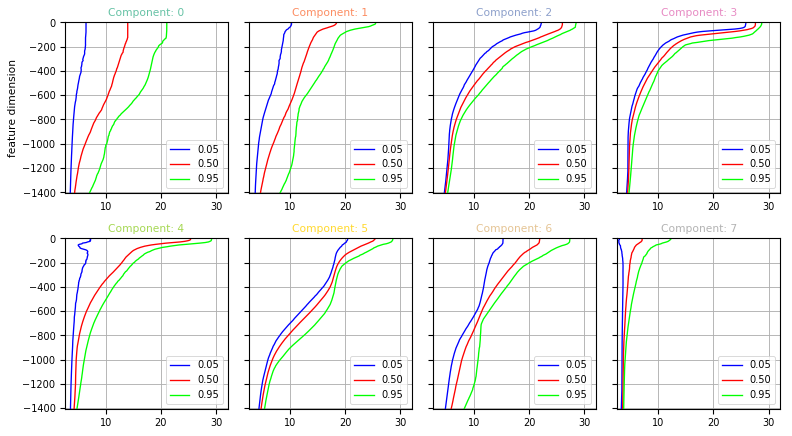

In [9]:
fig, ax = pcmplot.quant(m, ds['TEMP_Q'], maxcols=4, figsize=(10, 8), sharey=True)